# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy import interpolate
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
import scipy.ndimage.morphology as morph
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
import torch.nn.functional as F

import sys, os
import copy

os.environ["CUDA_VISIBLE_DEVICES"]=""

sys.path.append("../../../")
from source.pipeline.model_manager import BaseScaler
from source.pipeline.models.highresnet import HighResNet
from source.pipeline.models.highresnet_rprc import HighResNet_RPRC
from source.pipeline.models.highresnet_rprcdo import HighResNet_RPRCDO
from source.pipeline.losses.baseline_loss import MSELoss, L1Loss
from source.pipeline.entropy import Entropy

from source.pipeline.metrics_denoised_hist import DenoisedHistogram
from source.pipeline.metrics import *

from source.patch_stitch import get_patch
from source.patch_stitch import get_img_from_patch
from source.multiframe import register
from source.prep import map_prep


from source.utils import create_hist_bins

from skimage.transform import resize

import torch
import torch.nn as nn
import yaml

from reproject import reproject_exact, reproject_interp #use reproject_interp if you want it done quicker.

%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

device = torch.device('cpu')

## Load source GONG magnetogram



In [6]:
GONGmap = map_prep('/data-convert/GONG/2011/03/mlzqa110314/mlzqa110314t2034.fits.gz', 'GONG')

x, y = np.meshgrid(*[np.arange(v.value) for v in GONGmap.dimensions]) * u.pixel
hpc_coords = GONGmap.pixel_to_world(x, y)
rSunG = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / GONGmap.rsun_obs

GONGmap.data[rSunG>1] = np.nan

## Super-resolve GONG

In [7]:
## GONG

# # # # MSE + SSIM + Hist + Grad
run = 'to-ml-rp-gong_20201214200251_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP'
epoch = 'epoch_19'
runeval = 'to-ml-rp-gong_20210212160640_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP'
suffix = 'test'
config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP.yml'
label = 'GONG_SSIMGradHist_HSSIM'
title = 'MSE + SSIM\n+Grad +Hist'
Ylabels = False

# # # # # MSE + SSIM + Hist + Grad D1
run = 'to-ml-rp-gong_20210129203433_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D1'
epoch = 'epoch_19'
runeval = 'to-ml-rp-gong_20210213233720_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D1' 
suffix = 'test'
config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP_D1.yml'
label = 'GONG_SSIMGradHist_HSSIM_D1'
title = 'MSE + SSIM\n+Grad +Hist'
# Cal=0.85

# # # # # MSE + SSIM + Hist + Grad D2
# run = 'to-ml-rp-gong_20210206064501_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D2'
# epoch = 'epoch_2'
# runeval = 'to-ml-rp-gong_20210213005525_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D2'
# suffix = 'test'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP_D2.yml'
# label = 'GONG_SSIMGradHist_HSSIM_D2'
# title = 'MSE + SSIM\n+Grad +Hist'
# # Cal = 0.85


bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('checkpoints/' + run + '/' + epoch)
file = blob.download_to_filename('/tmp/checkpoint')


# Load config
with open(config_path, 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.SafeLoader)

# Set cuda to False as in config is true
config_data['cuda_device'] = False
print(config_data)    
    
# Create HighResnet
model = BaseScaler.from_dict(config_data)

#Load checkpoint to cpu
device = torch.device("cpu")
checkpoint = torch.load('/tmp/checkpoint', map_location=device)

#remove extra layaer from dict due to multi CPU traing
state_dict={}
for key, value in checkpoint['model_state_dict'].items():
#     print(np.append(['module'], key.split('.')[0:]))
    new_key = '.'.join(key.split('.')[1:])
    state_dict[new_key] = value
# state_dict=checkpoint['model_state_dict']

model.net.load_state_dict(state_dict)
model.net

{'cuda_device': False, 'data': {'data_bucket': '/gong-hmi', 'data_folder': 'to-ml-rp-gong', 'normalisation': 3500.0}, 'net': {'name': 'HighResNet_RPRCDO', 'upscale_factor': 1, 'n_frames': 1, 'p': 0.0}, 'loss': {'name': 'SSIMGradHistLoss', 'dl': 0.15, 'noise_level': 60, 'lim': 5000, 'coeff_hist': 1e-06, 'coeff_ssim': 0.0005, 'coeff_grad': 5}, 'learning_rate': 0.0001, 'beta1': 0.5, 'batch_size': 128, 'is_gradient': True, 'nepochs': 20, 'comment': 'SSIMGradHistLoss_gong_RP_D1'}
2021-02-15 - 20:59:15 INFO source.pipeline.model_manager: SSIMGradHistLoss(
  (ssim_loss): SSIM()
  (mseloss): MSELoss()
  (Hist): DenoisedHistogram(
    (conv1): Conv2d(1, 37, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(37, 37, kernel_size=(1, 1), stride=(1, 1))
  )
)


HighResNet_RPRCDO(
  (encode): Encoder(
    (init_layer): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): Dropout(p=0.0)
      (3): PReLU(num_parameters=1)
    )
    (res_layers): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (2): PReLU(num_parameters=1)
          (3): ReflectionPad2d((1, 1, 1, 1))
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): Dropout(p=0.0)
          (6): PReLU(num_parameters=1)
        )
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (2): PReLU(num_parameters=1)
          (3): ReflectionPad2d((1, 1, 1, 1))
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): Dr

In [8]:
# Load data into correct format and normalise
in_fd = np.stack([GONGmap.data/config_data['data']['normalisation'], rSunG], axis=0)
in_fd = in_fd[None]

# Transform to tensor and send to CPU
in_fd_t = torch.from_numpy(in_fd).to(device).float()

# Set model to eval mode and run FD inference
scale_factor = config_data['net']['upscale_factor']

new_meta = GONGmap.meta.copy() 
new_meta['crpix1'] = (new_meta['crpix1'] - GONGmap.data.shape[0] / 2 - 0.5) * scale_factor + GONGmap.data.shape[0] * scale_factor / 2 + 0.5
new_meta['crpix2'] = (new_meta['crpix2'] - GONGmap.data.shape[1] / 2 - 0.5) * scale_factor + GONGmap.data.shape[1] * scale_factor / 2 + 0.5
new_meta['cdelt1'] = new_meta['cdelt1'] / scale_factor
new_meta['cdelt2'] = new_meta['cdelt2'] / scale_factor
# new_meta['r_sun'] = new_meta['r_sun'] * scale_factor


GONGmapHR = sunpy.map.Map(model.forward(in_fd_t).detach().numpy()[0,...]*config_data['data']['normalisation'], new_meta)
x, y = np.meshgrid(*[np.arange(v.value) for v in GONGmapHR.dimensions]) * u.pixel
hpc_coords = GONGmapHR.pixel_to_world(x, y)
rSunIG = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / GONGmapHR.rsun_obs

GONGmapHR.data[rSunIG>1] = np.nan

noise = np.random.normal(loc=0.0, scale=4, size=GONGmapHR.data.shape)
np.min(noise)

-18.037051979604048

## Load Target HMI magnetogram

In [9]:
HMImap = map_prep('/data-convert/HMI/2011/03/14/hmi.M_720s.20110314_221200_TAI.1.magnetogram.fits', 'HMI')

x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
rSunH = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs

# Mask data and rSun array to be on disk only
HMImap.data[rSunH>0.99] = np.nan

## Reproject `hmi_map` to  `gong_map`

In [10]:
output, footprint = reproject_interp(HMImap, GONGmapHR.wcs, GONGmapHR.data.shape)
gong_hmi_map = sunpy.map.Map(output, GONGmapHR.wcs)

## Plot GONG source, output and target

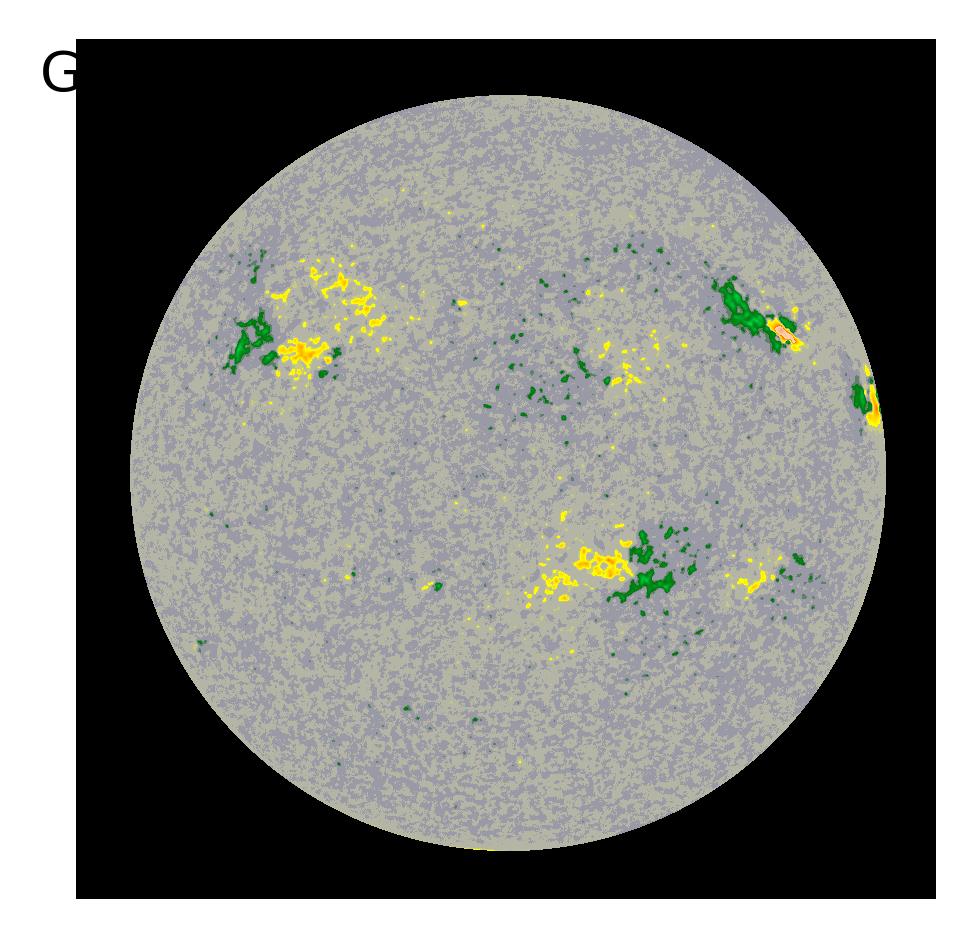

In [11]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(GONGmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


fig.savefig('GONG_Input_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

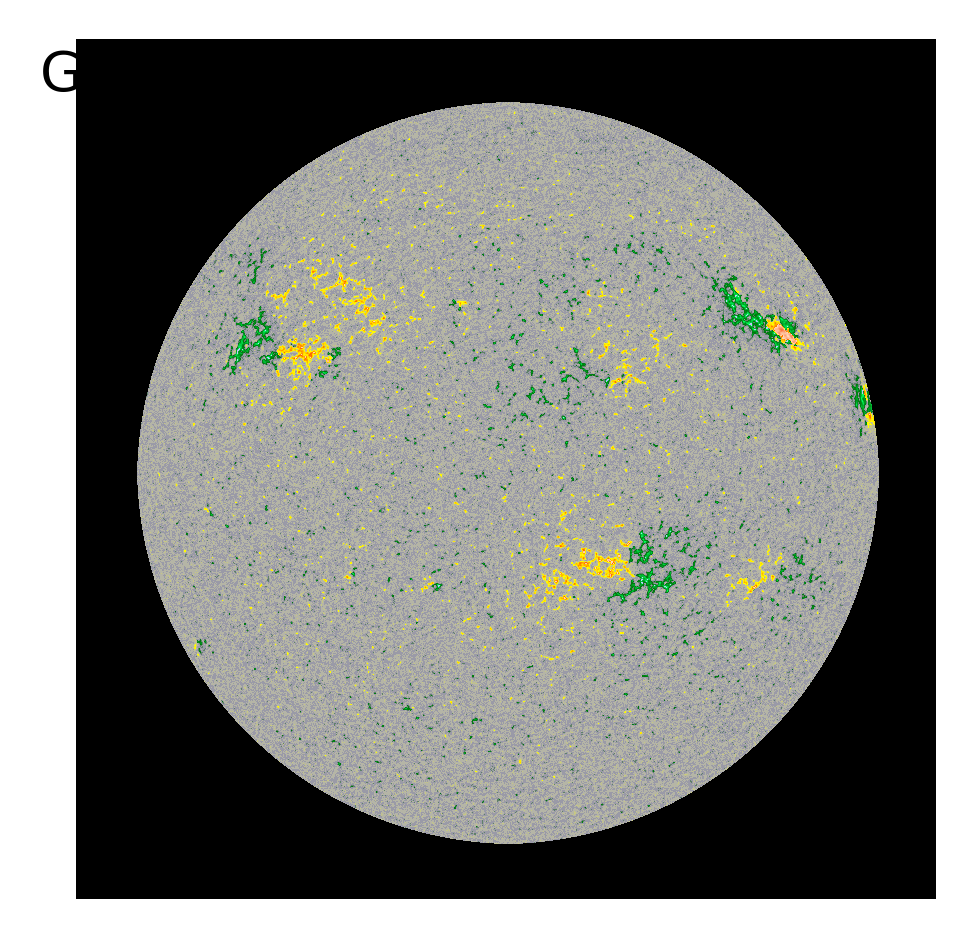

In [12]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

noise = np.random.normal(loc=0.0, scale=6, size=GONGmapHR.data.shape)
# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(GONGmapHR.data+noise, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


fig.savefig('GONG_Output_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

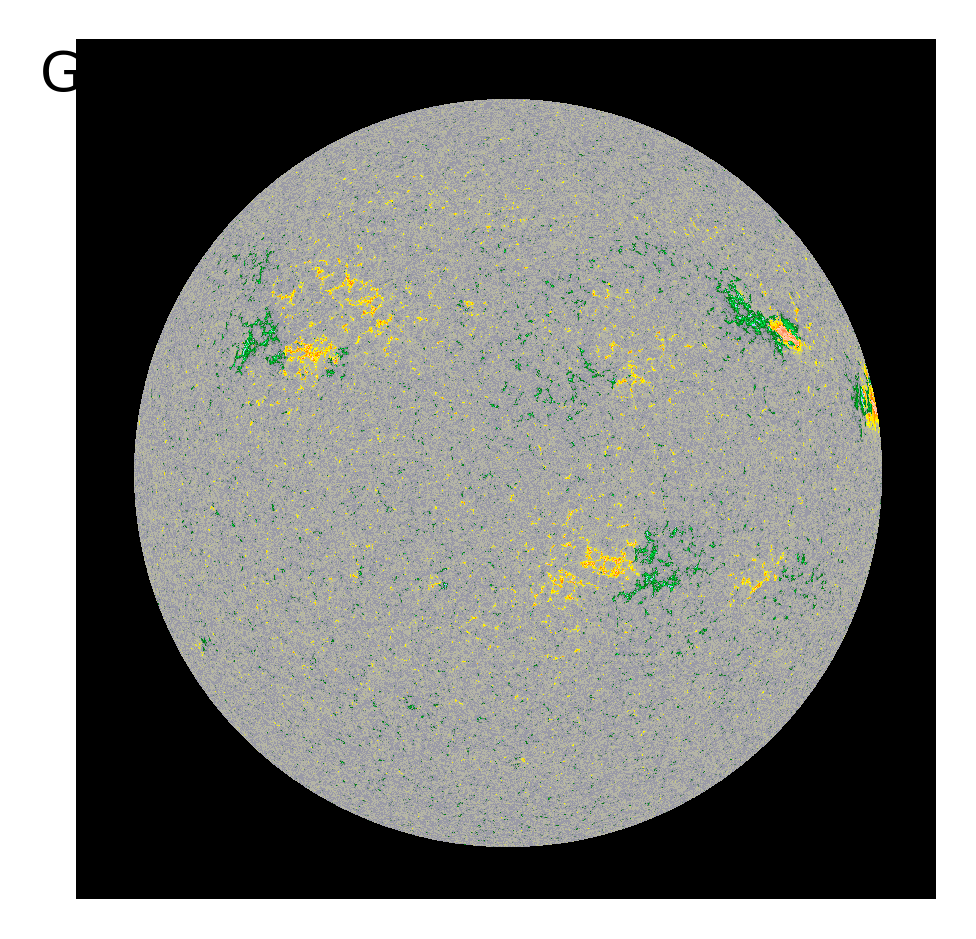

In [13]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(gong_hmi_map.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


fig.savefig('GONG_Target_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

# Estimation of uncertainty

In [14]:
bins = create_hist_bins()
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

min_no_samples = 100
limit_field = 2400

# blob = bucket.blob('inference/' + runeval + '/histogram_target_output_Sh_' + suffix +'.npy')
# file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
# hist2_to_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
blob = bucket.blob('inference/' + runeval + '/histogram_target_output_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_to_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_to_er = hist2_to_er_load
# hist2_to_er = np.sum(hist2_to_er_load, axis=2)
# hist2_to_er = np.transpose(hist2_to_er)


# Removing bins with few samples
hist2_to_er[:,np.sum(hist2_to_er,axis=0)<min_no_samples]=0

# Removing high fields
hist2_to_er[:,np.abs(centers)>limit_field]=0

x, y = np.meshgrid(widths,widths)
norm_to_er=hist2_to_er/(x*y)/np.nansum(hist2_to_er)
norm_to_ery = hist2_to_er/y/np.repeat(np.nansum(hist2_to_er, axis=0)[None, :], norm_to_er.shape[0], axis=0)


# Calculate cummulative integral
cdf_to_ery = np.nancumsum(norm_to_ery*y, axis=0)

# Plot histograms

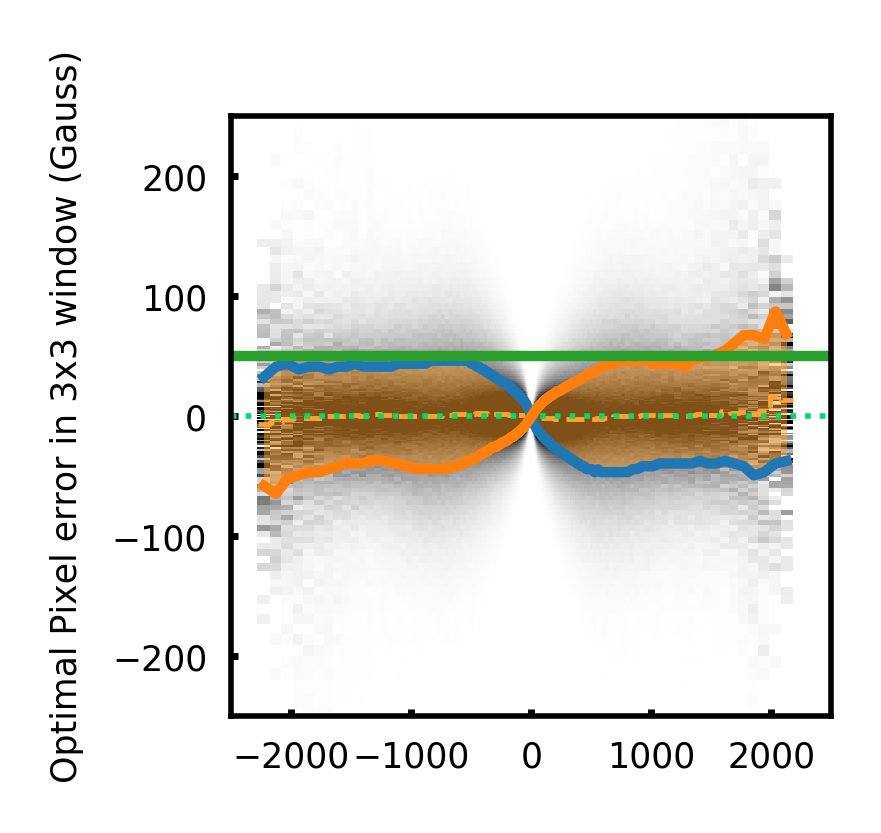

In [15]:
ftsz = 4

cmax = 700

ax_lim = 2500
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

index = np.sum(cdf_to_ery<=0.5,axis=0)
index[index==index.shape[0]] -= 1
median = centers[index]
median[np.abs(centers)>limit_field] = np.nan
median[np.abs(median)==np.max(centers)] = np.nan

index = np.sum(cdf_to_ery<=0.15,axis=0)
index[index==index.shape[0]] -= 1
perL = centers[index]
perL[np.abs(centers)>limit_field] = np.nan
perL[np.abs(perL)==np.max(centers)] = np.nan

index = np.sum(cdf_to_ery<=0.85,axis=0)
index[index==index.shape[0]] -= 1
perH = centers[index]
perH[np.abs(centers)>limit_field] = np.nan
perH[np.abs(perH)==np.max(centers)] = np.nan


# Inferred
ax3 = fig.add_axes([ppadh, ppadv-ppxy/2, ppxx/2, ppxy/2])

ax3.pcolor(bins,bins,norm_to_ery, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

ax3.plot(centers,median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax3.fill_between(centers, perL, perH, fc='#ffa232', alpha=0.5, ec='None', step='mid')


ax3.set_ylabel('Optimal Pixel error in 3x3 window (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax3.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax3.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax3.set_ylim([-ax_lim/10, ax_lim/10])
ax3.set_xlim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')

# Combining f15 and f85 to generate high and low bounds in amplitude

HB = perH.copy()
LB = perL.copy()

mid_index = (centers==0).nonzero()[0][0]

HB[0:mid_index] = perL[0:mid_index] 
LB[0:mid_index] = perH[0:mid_index] 

fL = interpolate.interp1d(centers, LB)
fH = interpolate.interp1d(centers, HB)

x = np.linspace(np.nanmin(centers), np.nanmax(centers), 1000)
ax3.plot(x, fL(x))
ax3.plot(x, fH(x))
ax3.plot([-ax_lim, ax_lim], [50, 50])




# fig.savefig(label + '_scatter_percentiles.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

# Plot negative error

In [16]:
# err_cmap = plt.cm.get_cmap('seismic')
err_cmap = plt.cm.get_cmap('magma')
err_cmap.set_bad(color='black')
e_vmax = 250
e_vmin = -250

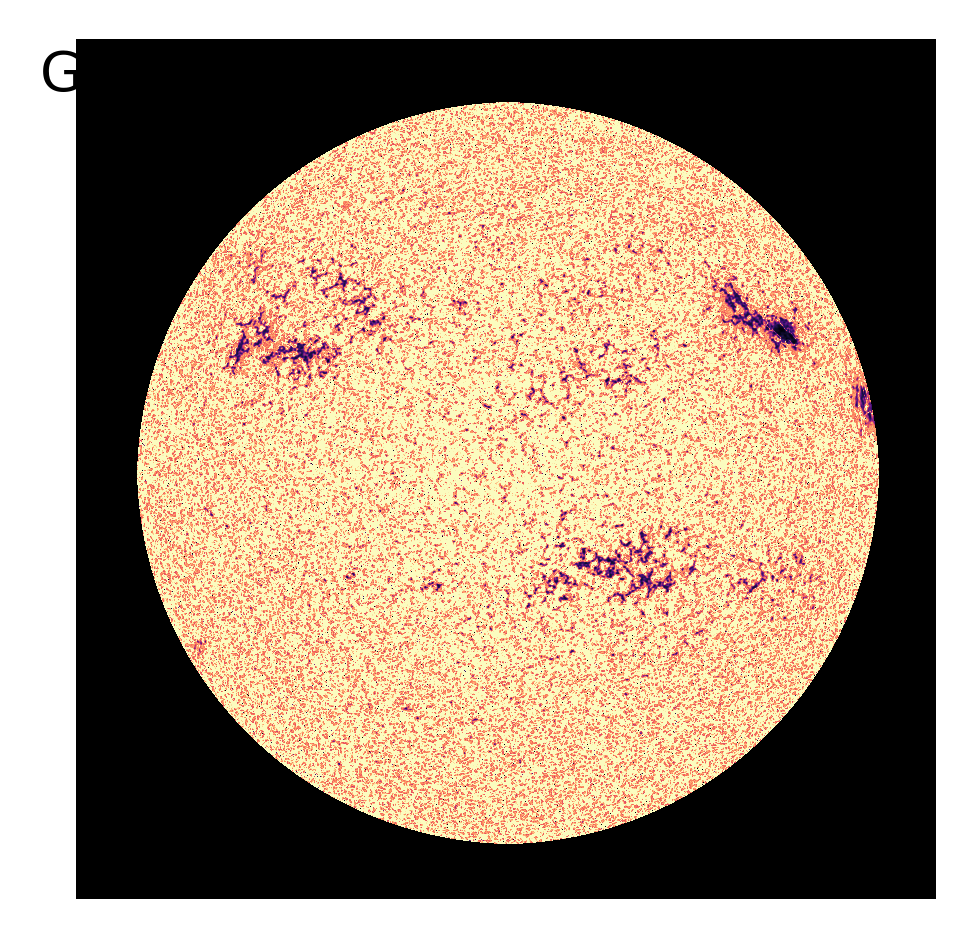

In [22]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

noise = np.random.normal(loc=0.0, scale=6, size=GONGmapHR.data.shape)
# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
# ax1.imshow(np.abs(fL(GONGmapHR.data))/np.abs(GONGmapHR.data)*100, vmin=e_vmin, vmax=e_vmax, cmap = err_cmap, origin='lower', interpolation='nearest')
ax1.imshow(np.power(np.abs(fL(GONGmapHR.data)),2)/np.power(np.abs(GONGmapHR.data),2)*100, vmin=0, vmax=10, cmap = err_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)

# 
fig.savefig('GONG_Output_FD_relative_Error.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

Text(0.99, 0.99, 'GONG_SSIMGradHist_HSSIM_D1')

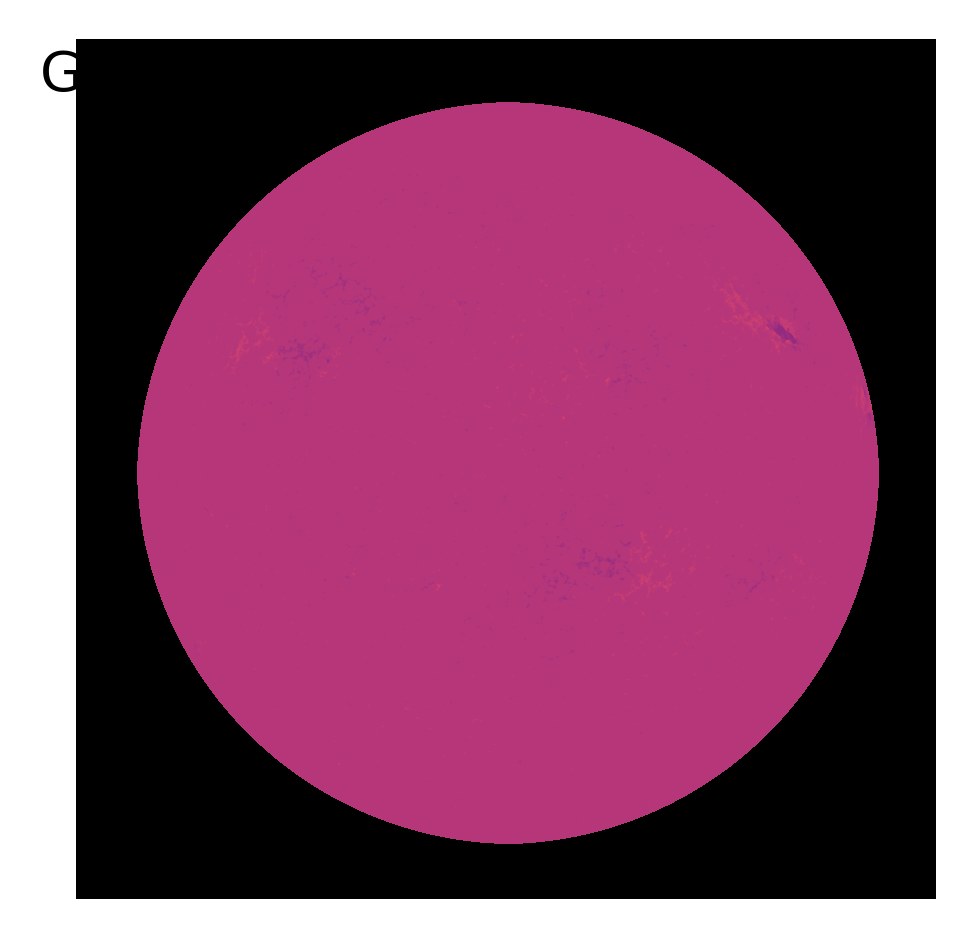

In [18]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

noise = np.random.normal(loc=0.0, scale=6, size=GONGmapHR.data.shape)
# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(fH(GONGmapHR.data), vmin=e_vmin, vmax=e_vmax, cmap = err_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


# fig.savefig('GONG_Output_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

# Plot lower and higher magnetogram bounds

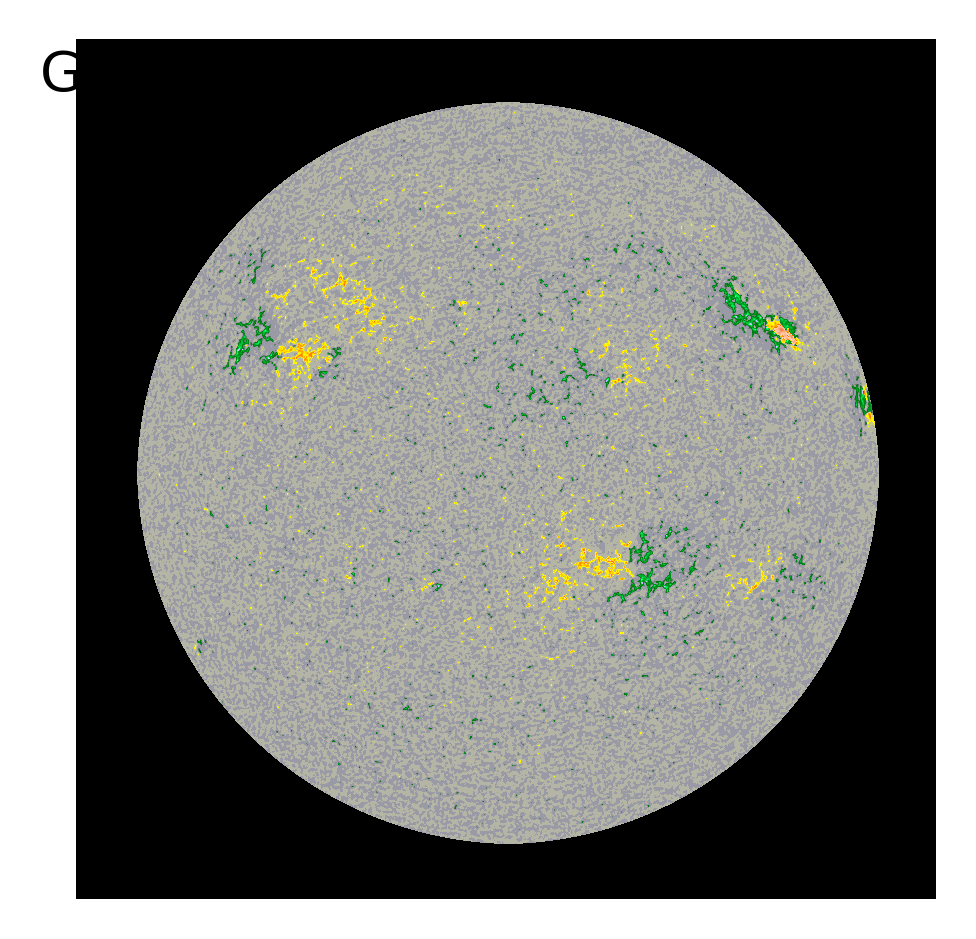

In [19]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

noise = np.random.normal(loc=0.0, scale=6, size=GONGmapHR.data.shape)
# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(GONGmapHR.data+fL(GONGmapHR.data), vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


fig.savefig('GONG_Output_FD_LB.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

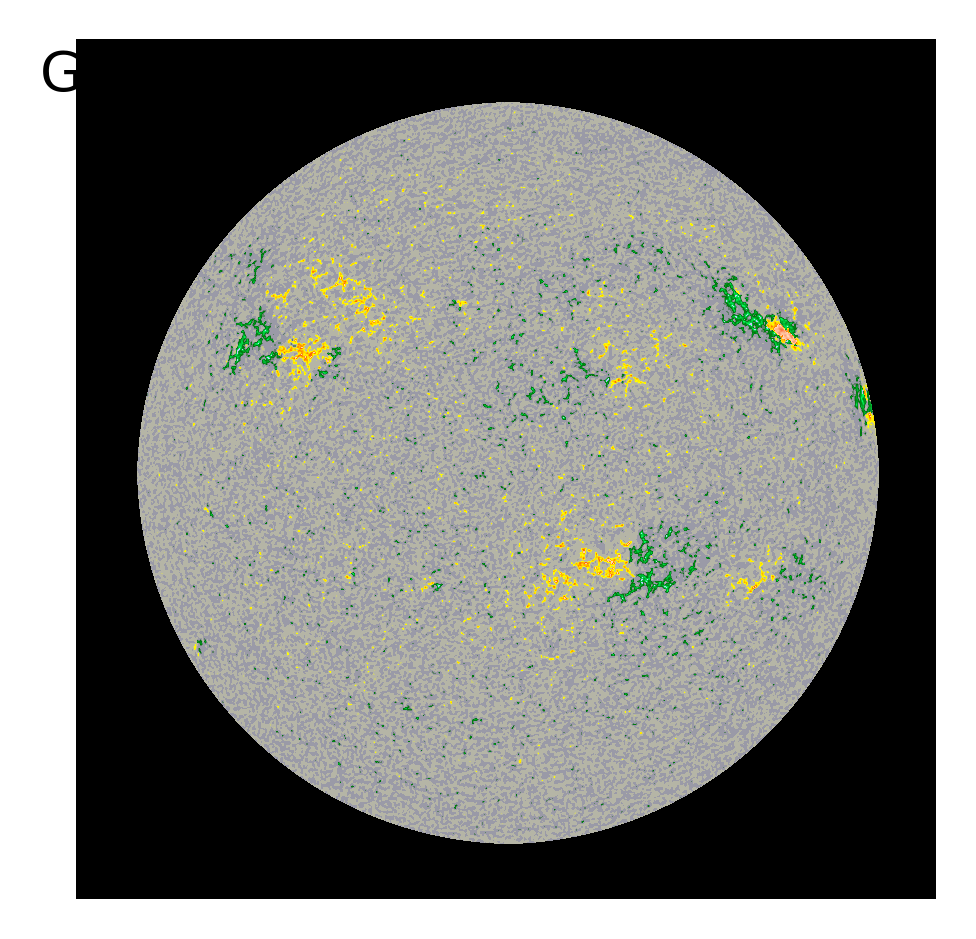

In [20]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between paneals in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

noise = np.random.normal(loc=0.0, scale=6, size=GONGmapHR.data.shape)
# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(GONGmapHR.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


fig.savefig('GONG_Output_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

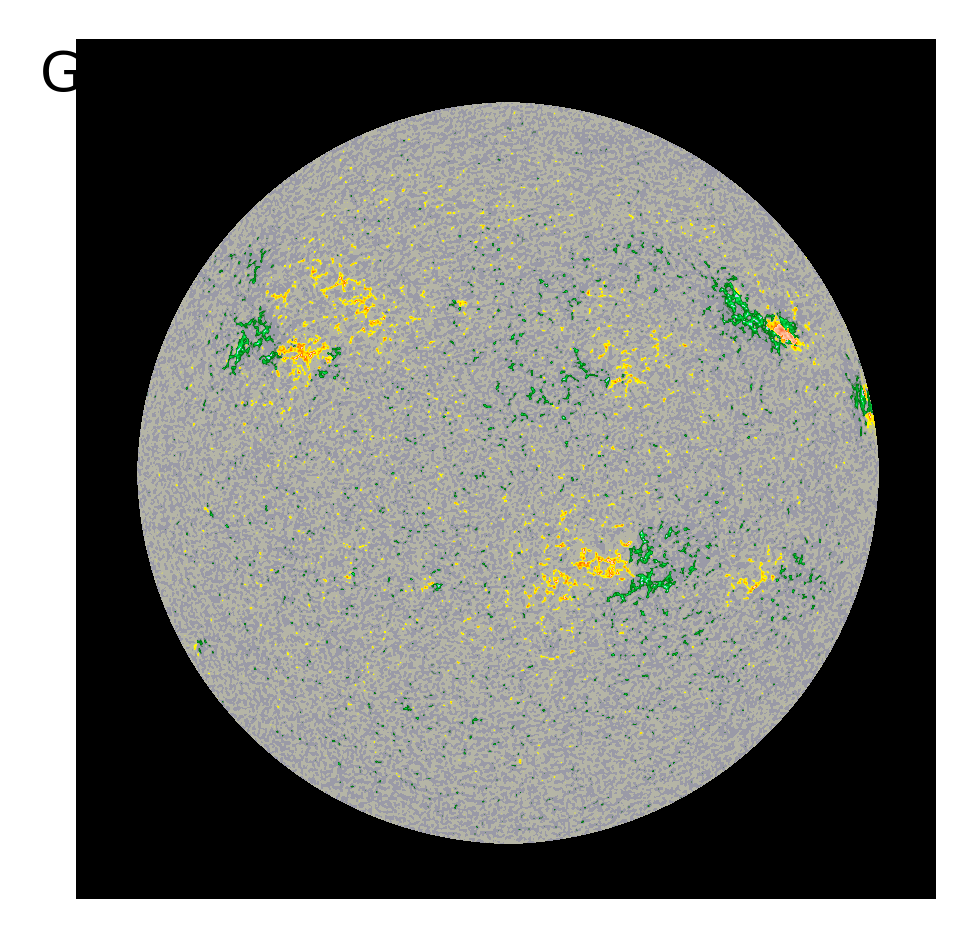

In [21]:
# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = GONGmapHR.data.shape[0]   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

noise = np.random.normal(loc=0.0, scale=6, size=GONGmapHR.data.shape)
# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(GONGmapHR.data+fH(GONGmapHR.data), vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower', interpolation='nearest')
ax1.set_axis_off()
ax1.text(0.99, 0.99, label, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)


fig.savefig('GONG_Output_FD_HB.png', bbox_inches='tight', dpi = dpi, pad_inches=0)